In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

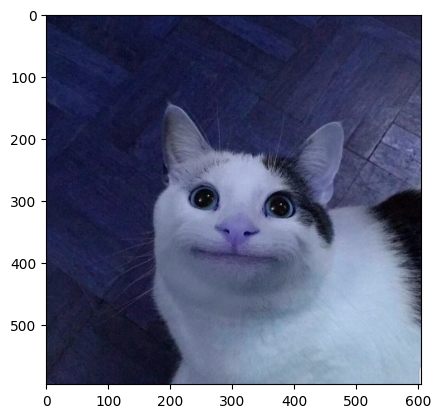

In [50]:
image = cv2.imread('./image.jpg')
plt.imshow(image);

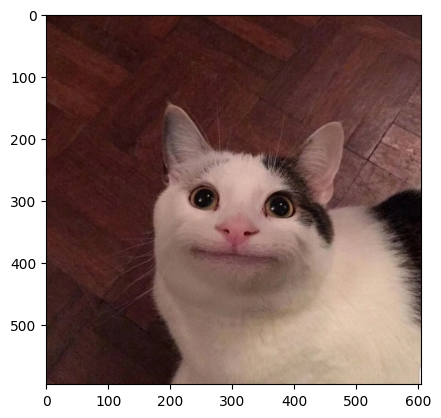

In [26]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

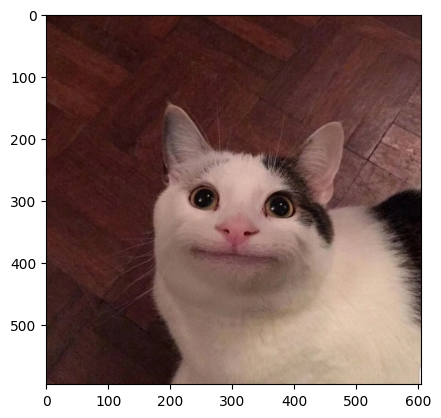

In [27]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

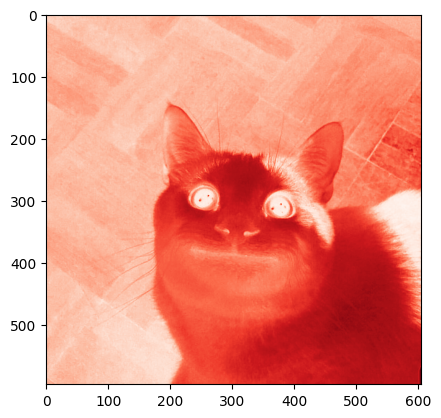

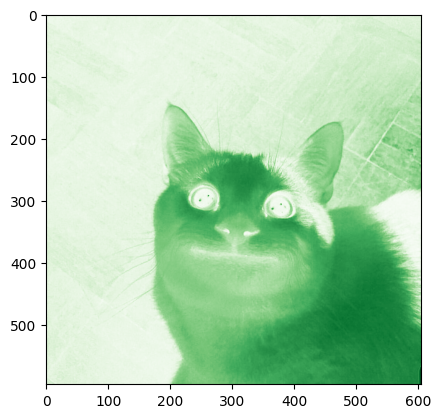

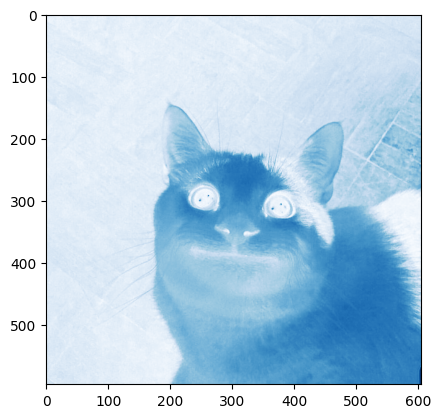

In [28]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)
![alt text](conv.png "")

In [35]:
bw_image = cv2.imread('./image.jpg', cv2.IMREAD_GRAYSCALE)

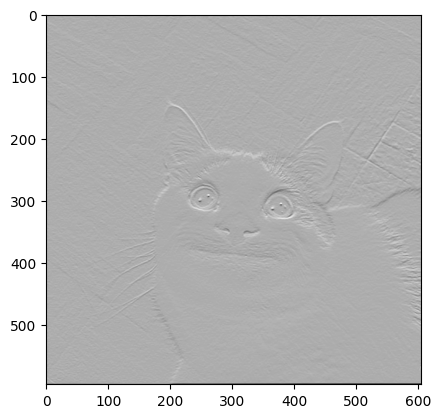

In [37]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

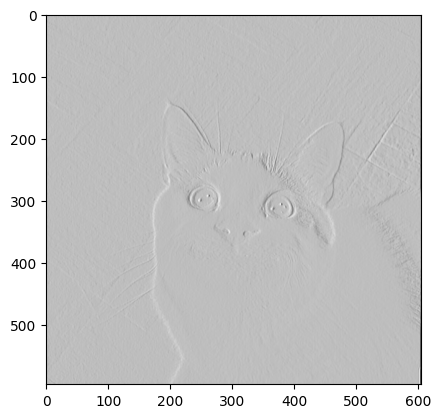

In [38]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

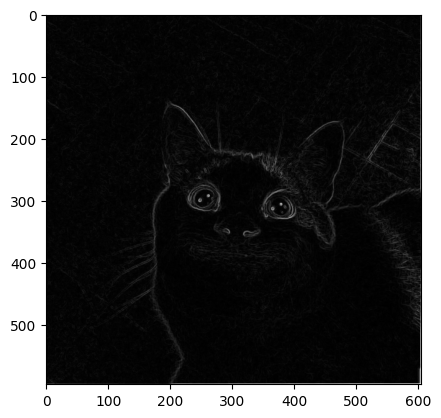

In [39]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [40]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

![alt text](pool.png "")

In [41]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):
    
    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [42]:
def max_pooling(pools: np.array) -> np.array:
    
    num_pools = pools.shape[0]
    
    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))
    
    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))
        
    return np.array(pooled).reshape(tgt_shape)

In [43]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [7]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm import tqdm

In [8]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [9]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

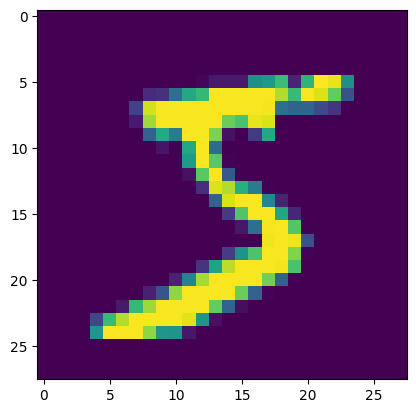

In [41]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [10]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        
            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [9]:
train(model, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 102.51it/s]


Epoch: 0, loss: 0.3185489773750305, accuracy: 0.9116


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.26it/s]


Epoch: 2, loss: 0.23119193315505981, accuracy: 0.9345


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 98.59it/s]

Epoch: 4, loss: 0.18472549319267273, accuracy: 0.9472


In [13]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон 
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [14]:
train(model, optimizer, F.cross_entropy)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.47it/s]


Epoch: 0, loss: 0.20922936499118805, accuracy: 0.9399


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.88it/s]


Epoch: 2, loss: 0.12076690047979355, accuracy: 0.9641


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.01it/s]

Epoch: 4, loss: 0.0797514095902443, accuracy: 0.9755


# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9746`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

# Анализ оптимизаторов
Посмотрим на самые популярные оптимизаторы: 
* Adam
* Adagrad 
* Adadelta
* RMSprop

In [94]:
def set_model():
    return nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон 
                        nn.Flatten(),
                        nn.Linear(6*6*10, 128),
                        nn.ReLU(),
                        nn.Linear(128, 10)
                    )

In [102]:
def train(model, optimizer, loss_function, n_epochs=5, plotting=True):
    if plotting:
        model_name = type(optimizer).__name__
        print(f"Optimizer: {model_name}")
        x = range(1, n_epochs + 1)
        errors = []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = loss_function(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        if plotting:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in val_dataloader:
                    y_pred = model(x_val)
                    loss = loss_function(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
                    
            errors.append(np.mean(val_accuracy))
            print(f'Epoch: {epoch + 1}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
    plt.plot(x, errors)
    plt.title(f'accuracy for {model_name}')
    plt.show()

In [ ]:
lr = 0.01
optimizer_list = (torch.optim.Adam,
                  torch.optim.Adagrad,
                  torch.optim.Adadelta,
                  torch.optim.RMSprop)

Optimizer: Adam


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.92it/s]


Epoch: 1, loss: 0.055635180324316025, accuracy: 0.981


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 55.58it/s]


Epoch: 2, loss: 0.08111464232206345, accuracy: 0.9748


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 58.49it/s]


Epoch: 3, loss: 0.0756639763712883, accuracy: 0.9789


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 59.23it/s]


Epoch: 4, loss: 0.07235057651996613, accuracy: 0.9828


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.85it/s]


Epoch: 5, loss: 0.07379747927188873, accuracy: 0.9811


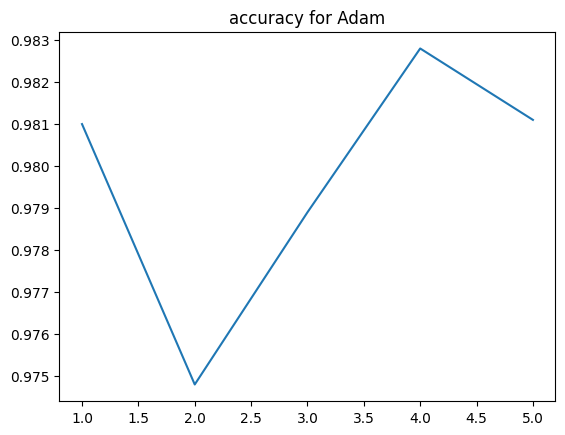

Optimizer: Adagrad


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.15it/s]


Epoch: 1, loss: 0.09405699372291565, accuracy: 0.9739


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 46.06it/s]


Epoch: 2, loss: 0.0721636638045311, accuracy: 0.9777


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:23<00:00, 40.47it/s]


Epoch: 3, loss: 0.06648516654968262, accuracy: 0.9791


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 42.75it/s]


Epoch: 4, loss: 0.05464988201856613, accuracy: 0.9821


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 42.76it/s]


Epoch: 5, loss: 0.051930733025074005, accuracy: 0.9841


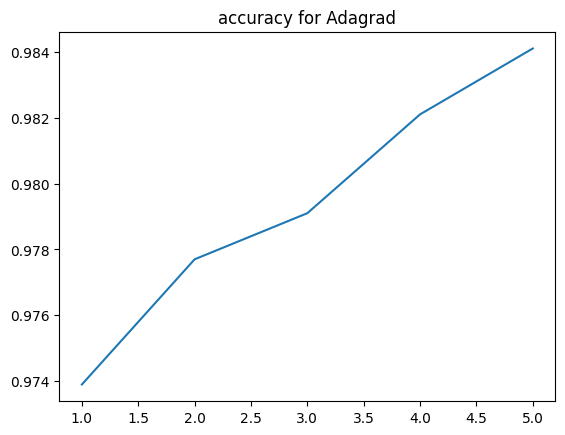

Optimizer: Adadelta


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.16it/s]


Epoch: 1, loss: 0.7431865930557251, accuracy: 0.8424


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.75it/s]


Epoch: 2, loss: 0.4178486168384552, accuracy: 0.8955


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.44it/s]


Epoch: 3, loss: 0.31626853346824646, accuracy: 0.9154


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.15it/s]


Epoch: 4, loss: 0.25990742444992065, accuracy: 0.9294


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.41it/s]


Epoch: 5, loss: 0.22470267117023468, accuracy: 0.939


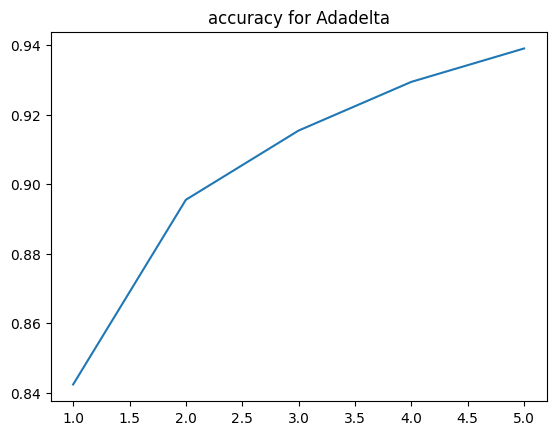

Optimizer: RMSprop


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.60it/s]


Epoch: 1, loss: 0.11048857867717743, accuracy: 0.9655


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.50it/s]


Epoch: 2, loss: 0.0777047723531723, accuracy: 0.9764


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.10it/s]


Epoch: 3, loss: 0.07427339255809784, accuracy: 0.9776


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 46.10it/s]


Epoch: 4, loss: 0.06610582023859024, accuracy: 0.9825


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 47.86it/s]


Epoch: 5, loss: 0.07555385679006577, accuracy: 0.9816


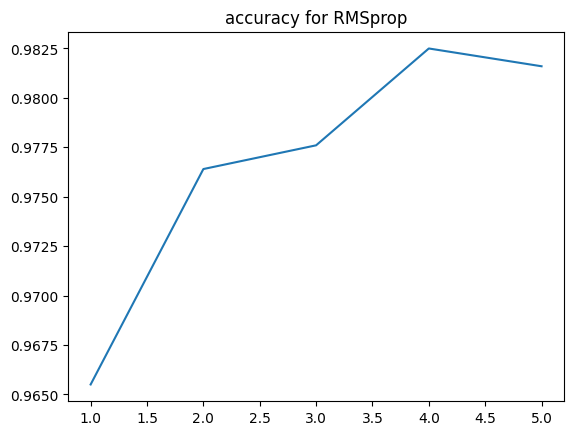

In [97]:
for optimizer in optimizer_list:
    model = set_model()
    
    train(model, optimizer(model.parameters(), lr=lr), F.cross_entropy)

### Лучшее accuracy показал Adagrad: 0.984 при epochs=5

# Анализ лоссов

In [211]:
loss_list = (F.nll_loss,
             F.kl_div)

In [220]:
def matrix_from_vector(shape, vector):
    res = torch.zeros(shape)
    for i in range(len(vector)):
        res[i][vector[i]]=1
    return res

In [228]:
def train(model, optimizer, loss_function, n_epochs=5, plotting=True):
    if plotting:
        loss_name = loss_function
        print(f"Loss: {loss_name}")
        x = range(1, n_epochs + 1)
        errors = []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            if loss_function==F.kl_div:
                ans = matrix_from_vector(y_pred.shape, y_train)
                loss = loss_function(F.log_softmax(y_pred), ans)
            else:
                loss = loss_function(F.log_softmax(y_pred), y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        if plotting:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in val_dataloader:
                    y_pred = model(x_val)
                    if loss_function==F.kl_div:
                        ans = matrix_from_vector(y_pred.shape, y_val)
                        loss = loss_function(F.log_softmax(y_pred), ans)
                    else:
                        loss = loss_function(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
                    
            errors.append(np.mean(val_accuracy))
            print(f'Epoch: {epoch + 1}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
    plt.plot(x, errors)
    plt.title(f'accuracy for {loss_name}')
    plt.show()

Loss: <function nll_loss at 0x000001C89B1A25E0>


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 41.76it/s]


Epoch: 1, loss: -9.89035701751709, accuracy: 0.9687


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 47.31it/s]


Epoch: 2, loss: -10.409843444824219, accuracy: 0.9757


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.61it/s]


Epoch: 3, loss: -10.764057159423828, accuracy: 0.9784


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 46.90it/s]


Epoch: 4, loss: -10.917567253112793, accuracy: 0.9822


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 47.37it/s]


Epoch: 5, loss: -11.117785453796387, accuracy: 0.9826


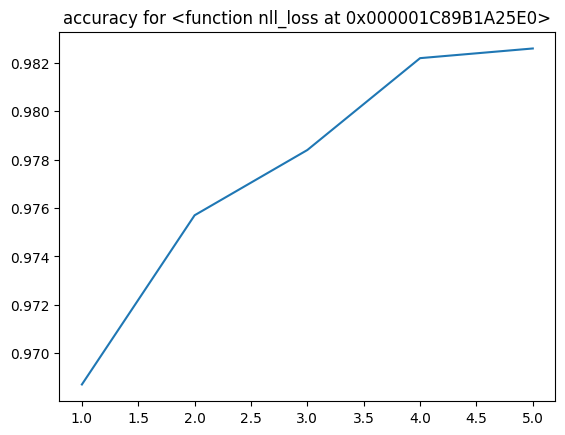

Loss: <function kl_div at 0x000001C89B1A2790>


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 44.81it/s]


Epoch: 1, loss: 0.01192067563533783, accuracy: 0.9628


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.10it/s]


Epoch: 2, loss: 0.0074225496500730515, accuracy: 0.9772


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.06it/s]


Epoch: 3, loss: 0.006169188302010298, accuracy: 0.9809


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 45.06it/s]


Epoch: 4, loss: 0.005690386984497309, accuracy: 0.9814


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 44.77it/s]


Epoch: 5, loss: 0.005585656967014074, accuracy: 0.9844


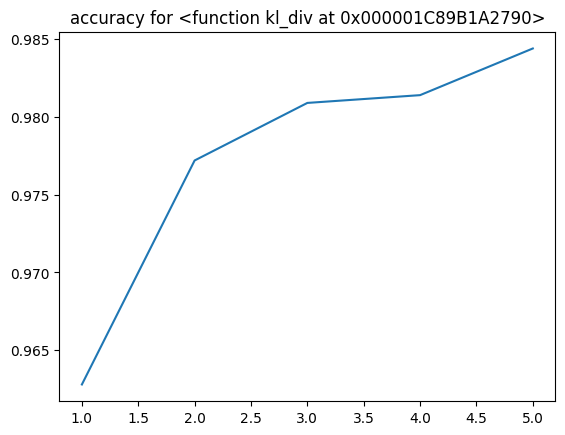

In [229]:
for loss in loss_list:
    model = set_model()
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
    train(model, optimizer, loss)

### Дивергенция Кульбака-Лейблера показывает себя так же хорошо, как и кросс-энтропия

# Изменение структуры CNN

In [104]:
def train(model, optimizer, loss_function, n_epochs=5, plotting=True):
    if plotting:
        model_name = type(optimizer).__name__
        print(f"Optimizer: {model_name}")
        loss_name = loss_function.__name__
        print(f"Loss: {loss_name}")
        x = range(1, n_epochs + 1)
        errors = []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = loss_function(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        if plotting:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in val_dataloader:
                    y_pred = model(x_val)
                    loss = loss_function(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
                    
            errors.append(np.mean(val_accuracy))
            print(f'Epoch: {epoch + 1}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
    plt.plot(x, errors)
    plt.title(f'accuracy for {model_name} with {loss_name} loss function and {int(model[0].out_channels / model[0].in_channels)} kernels count ')
    plt.show()

### Попробуем изменить количество пар слоев свертки - пулинга от 1 до 3. В каждом слое свертки будет по 4 ядра, а каждый пуллинг будет сокращать размерность в 2 раза

In [105]:
def set_models_with_different_length(n):
    models = [[] for _ in range(n)]
    in_channels = 1
    maps_count = 4
    pool_kernel_size = 2
    
    for i in range(n):
        for j in range(i, n):
            models[j].append(nn.Conv2d(in_channels=in_channels, out_channels=in_channels * maps_count, kernel_size=5, padding='same'))
            models[j].append(nn.ReLU())
            models[j].append(nn.MaxPool2d(kernel_size=pool_kernel_size))
            
        in_channels *= maps_count

    for i in range(n):
        models[i].append(nn.Flatten())
        models[i].append(nn.Linear(int(np.floor(28 / pool_kernel_size**(i + 1)))**2 * maps_count**(i + 1), 128))
        models[i].append(nn.ReLU())
        models[i].append(nn.Linear(128, 10))

    sequentials = [nn.Sequential(*model) for model in models]
    return sequentials

In [106]:
from torchsummary import summary

In [107]:
for model in set_models_with_different_length(3):
    summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]             104
              ReLU-2            [-1, 4, 28, 28]               0
         MaxPool2d-3            [-1, 4, 14, 14]               0
           Flatten-4                  [-1, 784]               0
            Linear-5                  [-1, 128]         100,480
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 101,874
Trainable params: 101,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.39
Estimated Total Size (MB): 0.45
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output

Convolution-subsampling pairs: 1
Optimizer: Adagrad
Loss: cross_entropy


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 57.13it/s]


Epoch: 1, loss: 0.11585427820682526, accuracy: 0.9661


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.66it/s]


Epoch: 2, loss: 0.08141389489173889, accuracy: 0.9744


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.88it/s]


Epoch: 3, loss: 0.06759391725063324, accuracy: 0.9775


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.74it/s]


Epoch: 4, loss: 0.06164133921265602, accuracy: 0.9801


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 57.08it/s]


Epoch: 5, loss: 0.05872602388262749, accuracy: 0.9805


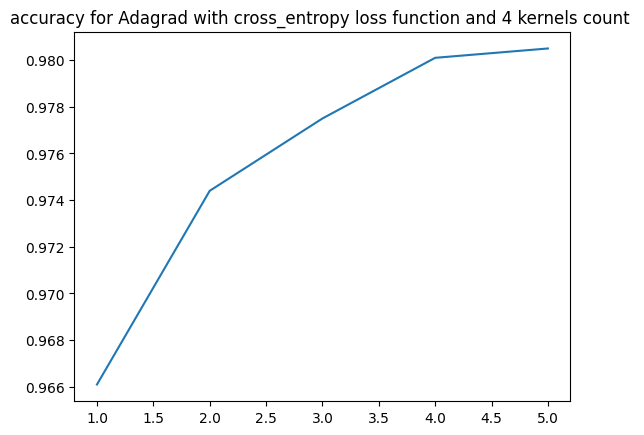

Convolution-subsampling pairs: 2
Optimizer: Adagrad
Loss: cross_entropy


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.47it/s]


Epoch: 1, loss: 0.07206781953573227, accuracy: 0.9767


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.00it/s]


Epoch: 2, loss: 0.05073722451925278, accuracy: 0.9844


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.20it/s]


Epoch: 3, loss: 0.042604196816682816, accuracy: 0.9869


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.34it/s]


Epoch: 4, loss: 0.0434504970908165, accuracy: 0.9861


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.51it/s]


Epoch: 5, loss: 0.038914673030376434, accuracy: 0.9872


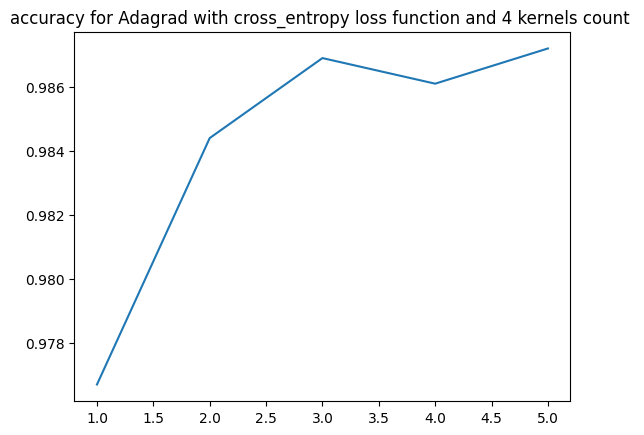

Convolution-subsampling pairs: 3
Optimizer: Adagrad
Loss: cross_entropy


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.91it/s]


Epoch: 1, loss: 0.06394731253385544, accuracy: 0.9791


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.66it/s]


Epoch: 2, loss: 0.07449310272932053, accuracy: 0.9733


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.23it/s]


Epoch: 3, loss: 0.04538533464074135, accuracy: 0.9853


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.68it/s]


Epoch: 4, loss: 0.03678639978170395, accuracy: 0.9875


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.59it/s]


Epoch: 5, loss: 0.034084852784872055, accuracy: 0.9888


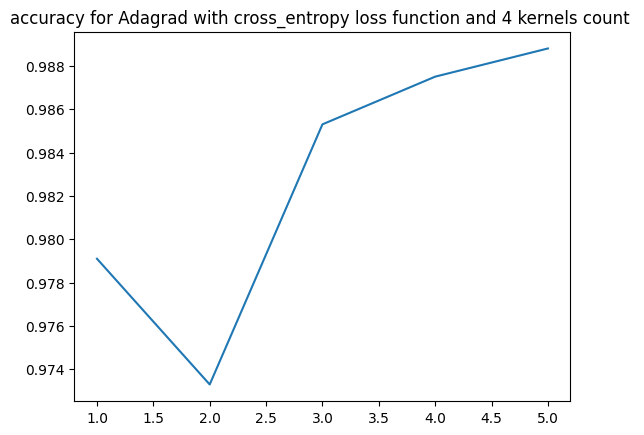

In [108]:
i = 1
for model in set_models_with_different_length(3):
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
    loss = F.cross_entropy
    print(f"Convolution-subsampling pairs: {i}")
    train(model, optimizer, loss)
    i += 1

### Для трех слоев скор получился наилучший - 0.9888

# Теперь поварьируем количество ядер - от 2 до 8 трехслойной CNN

In [109]:
def set_models_with_different_kernels(min, max, step):
    models = [[] for _ in range(int((max - min)/ step + 1))]
    in_channels = [1 for _ in range(len(models))]
    maps_count = [i for i in range(min, max + 1, step)]
    pool_kernel_size = 2

    for _ in range(3):
        for i in range(len(maps_count)):
            models[i].append(nn.Conv2d(in_channels=in_channels[i], out_channels=in_channels[i] * maps_count[i], kernel_size=5, padding='same'))
            models[i].append(nn.ReLU())
            models[i].append(nn.MaxPool2d(kernel_size=pool_kernel_size))
                
            in_channels[i] *= maps_count[i]

    for i in range(len(maps_count)):
        models[i].append(nn.Flatten())
        models[i].append(nn.Linear(int(np.floor(28 / pool_kernel_size**3))**2 * maps_count[i]**3, 128))
        models[i].append(nn.ReLU())
        models[i].append(nn.Linear(128, 10))

    sequentials = [nn.Sequential(*model) for model in models]
    return sequentials

In [110]:
for model in set_models_with_different_kernels(2, 8, 2):
    summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 28, 28]              52
              ReLU-2            [-1, 2, 28, 28]               0
         MaxPool2d-3            [-1, 2, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             204
              ReLU-5            [-1, 4, 14, 14]               0
         MaxPool2d-6              [-1, 4, 7, 7]               0
            Conv2d-7              [-1, 8, 7, 7]             808
              ReLU-8              [-1, 8, 7, 7]               0
         MaxPool2d-9              [-1, 8, 3, 3]               0
          Flatten-10                   [-1, 72]               0
           Linear-11                  [-1, 128]           9,344
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 11,698
Trainable params: 

Kernels count: 2
Optimizer: Adagrad
Loss: cross_entropy


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.61it/s]


Epoch: 1, loss: 0.17891576886177063, accuracy: 0.9448


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.82it/s]


Epoch: 2, loss: 0.14778302609920502, accuracy: 0.9542


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.96it/s]


Epoch: 3, loss: 0.12487909942865372, accuracy: 0.9604


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.83it/s]


Epoch: 4, loss: 0.1118684783577919, accuracy: 0.9652


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.81it/s]


Epoch: 5, loss: 0.10656189173460007, accuracy: 0.9667


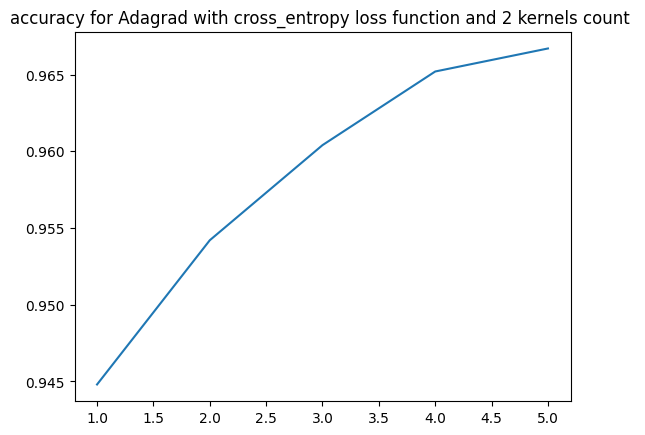

Kernels count: 4
Optimizer: Adagrad
Loss: cross_entropy


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.91it/s]


Epoch: 1, loss: 0.05731121450662613, accuracy: 0.9827


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.23it/s]


Epoch: 2, loss: 0.05010722577571869, accuracy: 0.9844


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.37it/s]


Epoch: 3, loss: 0.03529861941933632, accuracy: 0.9899


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.10it/s]


Epoch: 4, loss: 0.03977777436375618, accuracy: 0.9885


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.93it/s]


Epoch: 5, loss: 0.036799319088459015, accuracy: 0.9882


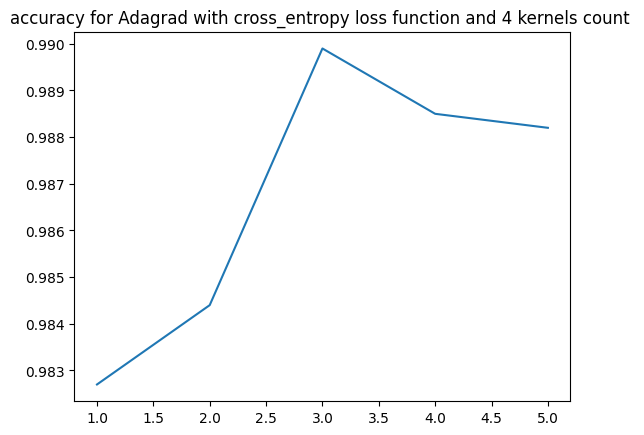

Kernels count: 6
Optimizer: Adagrad
Loss: cross_entropy


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:47<00:00, 19.63it/s]


Epoch: 1, loss: 0.04824346676468849, accuracy: 0.9843


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:48<00:00, 19.21it/s]


Epoch: 2, loss: 0.04351065680384636, accuracy: 0.9869


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:49<00:00, 18.92it/s]


Epoch: 3, loss: 0.031063243746757507, accuracy: 0.9909


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:49<00:00, 18.87it/s]


Epoch: 4, loss: 0.026407448574900627, accuracy: 0.9914


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:47<00:00, 19.85it/s]


Epoch: 5, loss: 0.02527984231710434, accuracy: 0.9922


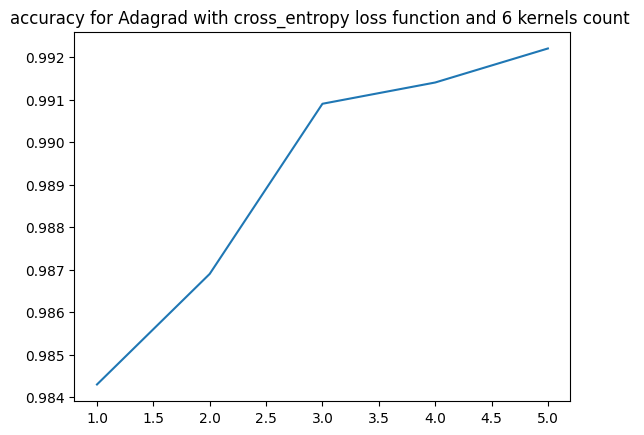

Kernels count: 8
Optimizer: Adagrad
Loss: cross_entropy


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:46<00:00,  8.83it/s]


Epoch: 1, loss: 0.06343945115804672, accuracy: 0.979


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:42<00:00,  9.13it/s]


Epoch: 2, loss: 0.039941344410181046, accuracy: 0.9868


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:43<00:00,  9.03it/s]


Epoch: 3, loss: 0.028465161100029945, accuracy: 0.9913


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:45<00:00,  8.92it/s]


Epoch: 4, loss: 0.027536215260624886, accuracy: 0.9905


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:43<00:00,  9.04it/s]


Epoch: 5, loss: 0.025105899199843407, accuracy: 0.9918


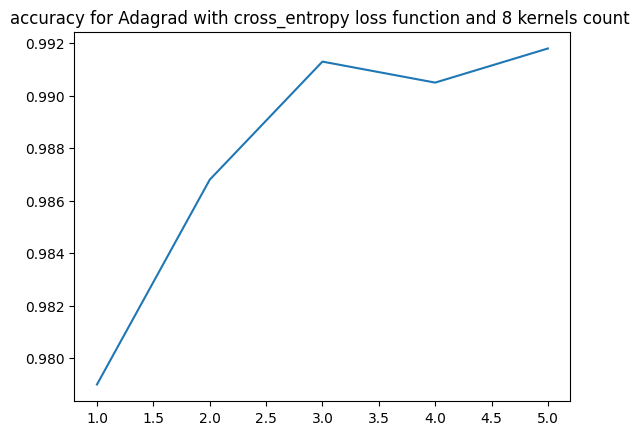

In [111]:
kernels = 2
for model in set_models_with_different_kernels(2, 8, 2):
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
    loss = F.cross_entropy
    print(f"Kernels count: {kernels}")
    train(model, optimizer, loss)
    kernels += 2

### Лучшая точность у модели с 6 ядрами - 0.9922

# Анализ ошибок (код из ДЗ №2)

In [115]:
network = model

In [150]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [151]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
test_dataset = MNIST('.', train=False, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [166]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    y = y.numpy()
    prediction = network(X)
    prediction = torch.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if torch.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(torch.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
            
wrong_X = np.array(wrong_X)
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = torch.stack(logits).detach().numpy()
logits = np.row_stack(logits)[:, 0]

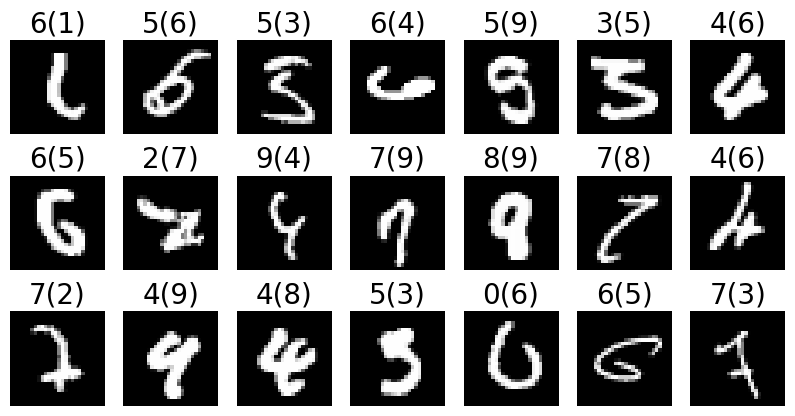

In [167]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Как видим, модель ошибается только на сильных выбросах